<a href="https://colab.research.google.com/github/my612/Quantamania/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
from itertools import product

# Define the distance matrix (example: 3 cities)
distance_matrix = np.array([
    [0, 1, 2],  # Distances from city 0
    [1, 0, 3],  # Distances from city 1
    [2, 3, 0]   # Distances from city 2
])

# Number of cities
n = distance_matrix.shape[0]

# QUBO matrix initialization
qubo_matrix = np.zeros((n**2, n**2))

# Penalty weights
P1 = 10  # Penalty for visiting a city more than once
P2 = 10  # Penalty for assigning multiple cities to one position

# Encode the objective function into QUBO
for i, j, t in product(range(n), range(n), range(n - 1)):
    if i != j:  # Avoid diagonal terms since d_ii = 0
        index_1 = i * n + t
        index_2 = j * n + (t + 1)
        qubo_matrix[index_1, index_2] += distance_matrix[i, j]

# Encode the constraints into QUBO
# Constraint 1: Each city is visited exactly once
for i in range(n):
    for t in range(n):
        index = i * n + t
        qubo_matrix[index, index] += P1 * (1 - 2 * np.sum([1 if t2 != t else 0 for t2 in range(n)]))
        for t2 in range(t + 1, n):
            index_2 = i * n + t2
            qubo_matrix[index, index_2] += 2 * P1

# Constraint 2: Each position in the route is occupied by exactly one city
for t in range(n):
    for i in range(n):
        index = i * n + t
        qubo_matrix[index, index] += P2 * (1 - 2 * np.sum([1 if i2 != i else 0 for i2 in range(n)]))
        for i2 in range(i + 1, n):
            index_2 = i2 * n + t
            qubo_matrix[index, index_2] += 2 * P2

# Print the QUBO matrix
print("QUBO Matrix:")
print(qubo_matrix)

# Save QUBO matrix to file (optional)
np.savetxt("qubo_matrix.txt", qubo_matrix, fmt="%.2f")


QUBO Matrix:
[[-60.  20.  20.  20.   1.   0.  20.   2.   0.]
 [  0. -60.  20.   0.  20.   1.   0.  20.   2.]
 [  0.   0. -60.   0.   0.  20.   0.   0.  20.]
 [  0.   1.   0. -60.  20.  20.  20.   3.   0.]
 [  0.   0.   1.   0. -60.  20.   0.  20.   3.]
 [  0.   0.   0.   0.   0. -60.   0.   0.  20.]
 [  0.   2.   0.   0.   3.   0. -60.  20.  20.]
 [  0.   0.   2.   0.   0.   3.   0. -60.  20.]
 [  0.   0.   0.   0.   0.   0.   0.   0. -60.]]


In [7]:
#import libraries
%matplotlib inline
import pulp
import pandas as pd
from scipy.spatial import distance_matrix
from matplotlib import pyplot as plt
import time
import copy


----------data--------------
       CITy        x        y
0     Delhi  77.2300  28.6600
1    Rājkot  70.7984  22.2969
2    Nāgpur  79.0831  21.1539
3   Kolkāta  88.3378  22.5411
4  Agartala  91.2667  23.8333
5    Dispur  91.7700  26.1500
-----------------------------


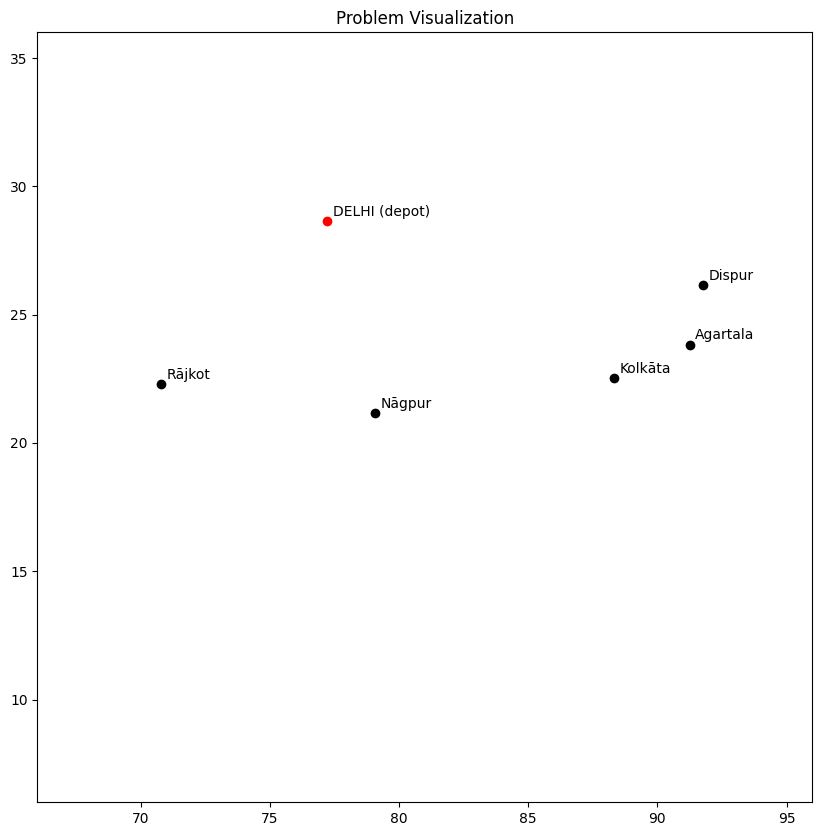

In [10]:

#This function takes locations as input and plot a scatter plot
def plot_fig(loc,heading="plot"):

    plt.figure(figsize=(10,10))
    for i,row in loc.iterrows():
        if i==0:
            plt.scatter(row["x"],row["y"],c='r')
            plt.text(row["x"]+0.2, row["y"]+0.2, 'DELHI (depot) ')
        else:
            plt.scatter(row["x"], row["y"], c='black')
            plt.text(row["x"] + 0.2, row["y"] + 0.2,full_data.loc[i]['CITy'] )
        plt.ylim(6,36)
        plt.xlim(66,96)
        plt.title(heading)
# this function takes route plan as input and return the ordered routes and subtours, if present
def get_plan(r0):
    r=copy.copy(r0)
    route = []
    while len(r) != 0:
        plan = [r[0]]
        del (r[0])
        l = 0
        while len(plan) > l:
            l = len(plan)
            for i, j in enumerate(r):
                if plan[-1][1] == j[0]:
                    plan.append(j)
                    del (r[i])
        route.append(plan)
    return(route)
# set no of cities
no_of_locs=6
data=pd.read_csv("tsp_city_data.csv")
full_data=data.iloc[0:no_of_locs,:]
d=full_data[['x','y']]
dis_mat=pd.DataFrame(distance_matrix(d.values,d.values),\
                       index=d.index,columns=d.index)
print("----------data--------------")
print(full_data)
print("-----------------------------")
plot_fig(d,heading="Problem Visualization")

plt.show()

-----------------
1 Optimal 47.095695134108254
[(0, 1), (1, 2), (2, 3), (3, 4), (4, 5), (5, 0)]
time taken by MTZ formulation =  0.11259245872497559


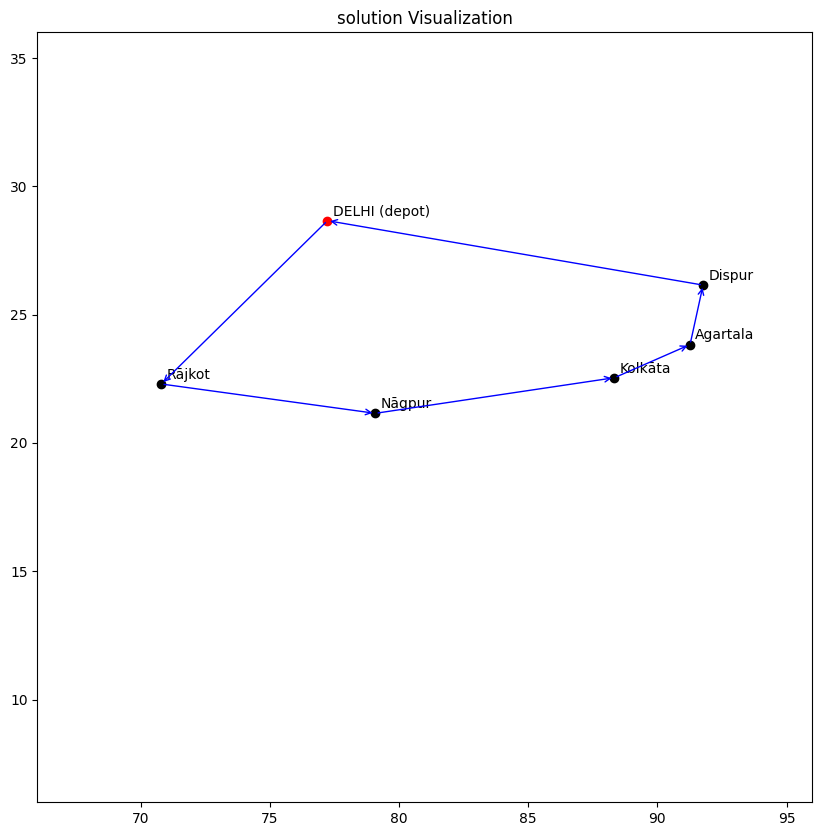

In [11]:
start_t=time.time()
model=pulp.LpProblem('tsp',pulp.LpMinimize)
#define variable
x=pulp.LpVariable.dicts("x",((i,j) for i in range(no_of_locs) \
                                for j in range(no_of_locs)),\
                           cat='Binary')
t = pulp.LpVariable.dicts("t", (i for i in range(no_of_locs)), \
                             lowBound=1,upBound= no_of_locs, cat='Continuous')
#set objective
model+=pulp.lpSum(dis_mat[i][j]* x[i,j] for i in range(no_of_locs) \
                      for j in range(no_of_locs))
# st constraints
for i in range(no_of_locs):
    model+=x[i,i]==0
    model+=pulp.lpSum(x[i,j] for j in range(no_of_locs))==1
    model += pulp.lpSum(x[j, i] for j in range(no_of_locs)) == 1
#eliminate subtour
for i in range(no_of_locs):
    for j in range(no_of_locs):
        if i!=j and (i!=0 and j!=0):
            model+=t[j]>=t[i]+1 - (2*no_of_locs)*(1-x[i,j])
status=model.solve()
#status=model.solver()
print("-----------------")
print(status,pulp.LpStatus[status],pulp.value(model.objective))
route=[(i,j) for i in range(no_of_locs) \
           for j in range(no_of_locs) if pulp.value(x[i,j])==1]
print(route)
plot_fig(d,heading="solution Visualization")
arrowprops = dict(arrowstyle='->', connectionstyle='arc3', edgecolor='blue')
for i, j in route:
    plt.annotate('', xy=[d.iloc[j]['x'], d.iloc[j]['y']],\
                      xytext=[d.iloc[i]['x'], d.iloc[i]['y']],\
                     arrowprops=arrowprops)
print("time taken by MTZ formulation = ", time.time()-start_t)
